# **GSAlign**
An efficient sequence alignment tool for intra-species genomes using BWT

In [46]:
import pandas as pd 
import numpy as np  
import random
from Bio import pairwise2
from Bio.Seq import Seq 

Overview of Paper:




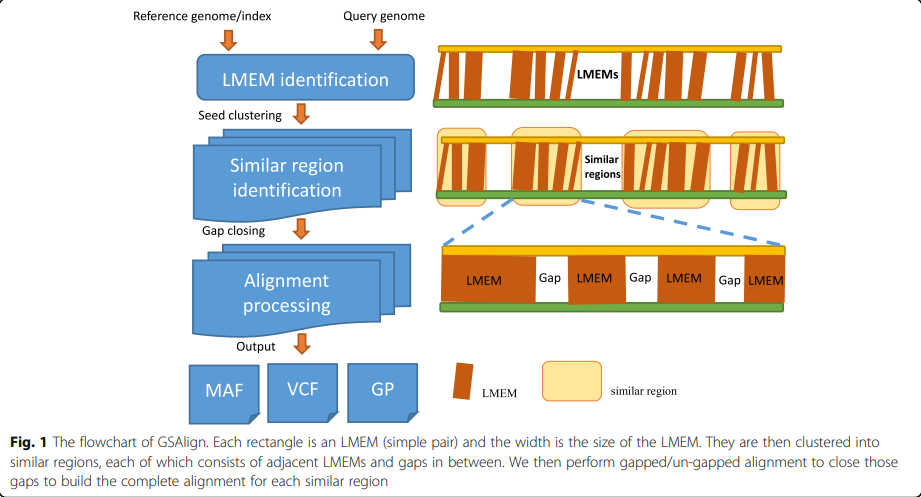

In [47]:
# for efficient exact matching, we use the Burrows-Wheeler transform for efficient exact matching

def bwt(p):
    """Burrows-Wheeler transform of a string"""
    if len(p)==0:
        return None
    s='$'+p
    rotations = list(enumerate([s[i:] + s[:i] for i in range(len(s))]))
    rotations.sort(key=lambda x: x[-1])
    df = pd.DataFrame([[rot[0],rot[1][0],rot[1][-1]] for rot in rotations])
    df.columns = ['index','L','R']

    
    letters = sorted(list(df['R'].unique()))
    rank = pd.DataFrame()
    for let in letters:
        rank[let] = (df['R']==let).cumsum() - (df['R']==let)
    
    rank.loc[len(s)]=df['R'].value_counts().sort_index()

    rng = pd.DataFrame([],index=letters)
    d = df['L'].value_counts().sort_index()
    rng['start']=d.cumsum() - d
    rng['end']=d.cumsum()
    
    return df ,rank,rng

In [48]:
# Uses BWT to get the exact matching regions in the 2 sequences

def get_lmem(q,df,rank,rng):
    """Burrows-Wheeler search of a string"""
    n =len(q)
    st,end = rng.loc[q[-1]]
    j2 = n-1
    lmem_list=[]
    # Threshold for the minimum length of lmem
    l_=10
    for j in range(n-2,-1,-1):
        q_ = q[j]
        st_ = rank.loc[st,q_]
        end_ = rank.loc[end,q_]
        
        if(st_==end_):
            j1 = j+1 
            l = j2-j1
            if(l>=l_-1):
                i1=df.iloc[st:end]['index'].values[0]-1
                i2 = i1 + l
                lmem_list.append((i1,i2+1,j1,j2+1,i1-j1))
            j2 = j
            st = rng.loc[q_,'start']
            end = rng.loc[q_,'end']

        elif j == 0:
            st = rng.loc[q_,'start'] + st_
            end = rng.loc[q_,'start'] + end_     
            j1 = j
            l = j2-j1
            if(l>=l_-1):
                i1=df.iloc[st:end]['index'].values[0]-1
                i2 = i1 + l
                lmem_list.append((i1,i2+1,j1,j2+1,i1-j1))

        else:
            st = rng.loc[q_,'start'] + st_
            end = rng.loc[q_,'start'] + end_
        
    return lmem_list  

**Making sets of alignments that are colinear**

In [49]:
# if two simple pair (locally aligned substring of seq1 and seq2) has similar position difference (that is difference in their startig position in sequence 2) 
# then they are collinear and in this function we are finding sets of such pairs. 

# If the starting position of the adjacent simple pairs, in the second sequence is less than the threshhold value, then they are added to the set.

def get_colinear_sets(lmem_list):
    """Get colinear sets from lmem_list"""
    lmem_list.sort(key=lambda x: x[-1])
    thresh = 25 
    colinear_sets = []
    l= [lmem_list[0]]
    for i in range(1,len(lmem_list)):
        if abs(lmem_list[i][-1]-lmem_list[i-1][-1])<=thresh:
            l.append(lmem_list[i])
        else:
            if(len(l)>1):
                colinear_sets.append(l)
            l = [lmem_list[i]]
    if len(l)>1:
        colinear_sets.append(l)
    return colinear_sets

**Removing Overlaps**

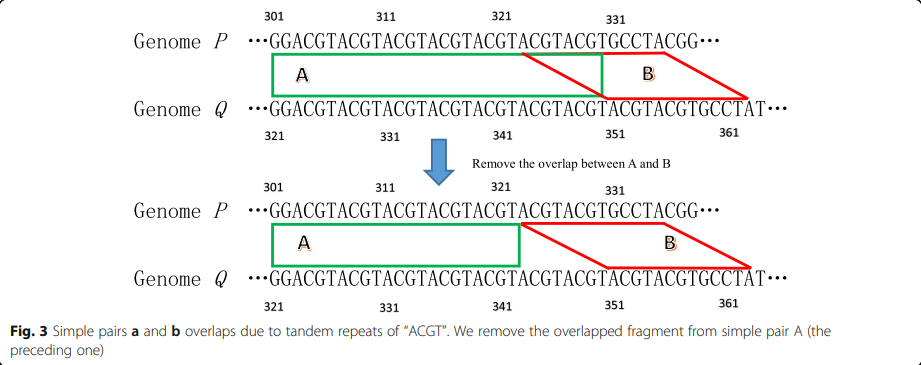

In [50]:
# Lets consider two simple pairs in the same cluster, sa =(ia,1; ia,2; ja,1; ja,2) and sb = (ib,1; ib,2; jb,1; jb,2)
# if ia,1 ≤ ib,1 ≤ ia,2 OR ja,1 ≤ jb,1 ≤ ja,2 then these pairs are overlapping. In such cases, we have to modify the pairs to remove the overlap

# In such cases, the overlapping fragment is chopped off from the smaller simple pair and is modifies accordingly

def remove_overlap(col_set):
    for i in range(len(col_set)-1):
        lmem1 = col_set[i]
        lmem2 = col_set[i+1]
        l1 = lmem1[1]-lmem1[0]
        l2 = lmem2[1]-lmem2[0]
        if lmem1[1]>lmem2[0]:
            if l1>l2:
                col_set[i+1] = [lmem1[1],lmem2[1],lmem2[2],lmem2[2]+lmem2[1]-lmem1[1],lmem2[2]-lmem1[1]]
            else:
                col_set[i] = [lmem1[0],lmem2[0],lmem1[2],lmem1[2]+lmem2[0]-lmem1[0],lmem1[4]]
    return col_set


**Removing outliers**

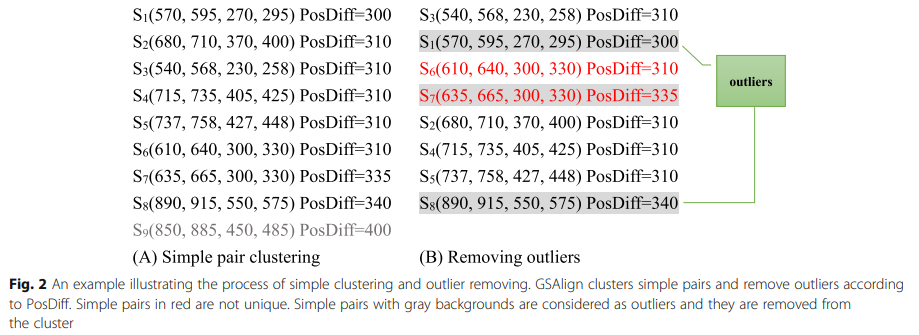

In [51]:
# Once the simple pairs are arranged according to the stariting position in the second sequence, we may have few pairs that are not
# co-linear with their adjacent simple pairs and they are considered as outliers, which need to be removed from the set. 

# For this, we define a threshold value and if the position difference between the adjacent simple pairs is less than that then they are 
# non-outliers. Set of such non-outliers is returned by this function.  

def non_outlier(col_set):
    col_set.sort(key=lambda x: x[2])
    thresh = 5
    n=len(col_set)
    dp = np.ones(n)
    for i in range(1,n):
        for j in range(i-1,-1,-1):
            if abs(col_set[i][-1]-col_set[j][-1])<=thresh:
                dp[i] = max(dp[i],dp[j]+1)
    i = dp.argmax()
    non_outlier_set = [col_set[i]]
    for j in range(i-1,-1,-1):
        if (abs(col_set[i][-1]-col_set[j][-1])<=thresh) and (dp[j]==dp[i]-1):
            non_outlier_set.append(col_set[j])
            i=j
    non_outlier_set.reverse()
    return non_outlier_set


In [52]:
# here we are returning the processed colinear set, that is after removing the outliers and handling the overlaps. 

def preprocess_colinear_sets(colinear_sets): 
    """Preprocess colinear sets"""
    for i in range(len(colinear_sets)):
        col_set = colinear_sets[i]
        col_set.sort(key=lambda x: x[2])
        col_set = non_outlier(col_set) # Remove outliers
        col_set = remove_overlap(col_set) # Remove overlaps
        colinear_sets[i] = col_set
    return colinear_sets

In [53]:
import fastaparser

p=""
q=""
with open("gene1.fasta") as fasta_file:
    parser = fastaparser.Reader(fasta_file)
    for seq in parser:
        print("Gene Sequence 1->")
        print('ID:', seq.id)
        print('Description:', seq.description)
        #print('Sequence:', seq.sequence_as_string())
        p=seq.sequence_as_string()
        print()
        
with open("gene2.fasta") as fasta_file:
    parser = fastaparser.Reader(fasta_file)
    for seq in parser:
        print("Gene Sequence 2->")
        print('ID:', seq.id)
        print('Description:', seq.description)
        #print('Sequence:', seq.sequence_as_string())
        q=seq.sequence_as_string()

Gene Sequence 1->
ID: NC_051348.1:62164080-6219770
Description: Ptgs2 [organism=Rattus norvegicus] [GeneID=29527] [chromosome=13]

Gene Sequence 2->
ID: NC_000067.7:14997578-149983985
Description: Ptgs2 [organism=Mus musculus] [GeneID=19225] [chromosome=1]


In [54]:
#p = ''.join([random.choice('ACGT') for i in range(500)]) #for easier visualization 100000
#q = ''.join([random.choice('ACGT') for i in range(500)])

# p='AAATTGGCC'
# q='AAACCGGCC'


In [55]:
print(len(p))
print(len(q))

5690
8203


In [56]:
df,rank,rng = bwt(p)
df

index  L  R
0         0  $  A
1      5690  A  A
2      5689  A  T
3       411  A  T
4      3029  A  C
...     ... .. ..
5686   4763  T  A
5687   4558  T  A
5688    660  T  C
5689   2739  T  T
5690   2738  T  A

[5691 rows x 3 columns]

In [57]:
lmem_set = get_lmem(q,df,rank,rng)
pd.DataFrame(lmem_set,columns=['i1','i2','j1','j2','offset'])

i1    i2    j1    j2  offset
0    3457  3469  8109  8121   -4652
1    2946  2956  7930  7940   -4984
2    1935  1946  7865  7876   -5930
3    5549  5559  7834  7844   -2285
4    1610  1621  7388  7399   -5778
..    ...   ...   ...   ...     ...
123   251   261   381   391    -130
124   131   148   312   329    -181
125     0    32   193   225    -193
126  2981  2991   109   119    2872
127   686   696    71    81     615

[128 rows x 5 columns]

In [58]:
# to get the colinear set of the simple pairs
colinear_sets = get_colinear_sets(lmem_set)
colinear_sets

[[(0, 32, 193, 225, -193),
  (131, 148, 312, 329, -181),
  (1414, 1427, 1594, 1607, -180),
  (1971, 1991, 2145, 2165, -174),
  (1899, 1923, 2073, 2097, -174),
  (1854, 1884, 2028, 2058, -174),
  (1833, 1843, 2007, 2017, -174),
  (1815, 1828, 1989, 2002, -174),
  (1765, 1789, 1939, 1963, -174),
  (1609, 1626, 1778, 1795, -169),
  (1561, 1580, 1730, 1749, -169),
  (1525, 1548, 1694, 1717, -169),
  (1504, 1516, 1673, 1685, -169),
  (1706, 1717, 1873, 1884, -167),
  (1660, 1680, 1827, 1847, -167),
  (1718, 1730, 1884, 1896, -166),
  (1484, 1495, 1649, 1660, -165),
  (1472, 1485, 1636, 1649, -164),
  (2053, 2063, 2213, 2223, -160),
  (2027, 2047, 2187, 2207, -160),
  (1365, 1393, 1523, 1551, -158),
  (1261, 1273, 1419, 1431, -158),
  (1078, 1126, 1235, 1283, -157),
  (1030, 1073, 1187, 1230, -157),
  (1008, 1021, 1165, 1178, -157),
  (924, 934, 1081, 1091, -157),
  (884, 895, 1041, 1052, -157),
  (857, 879, 1014, 1036, -157),
  (806, 819, 963, 976, -157),
  (783, 797, 940, 954, -157),
  (97

In [59]:
# to process the colinear set (removing ouliers and handling overlaps) obtained in previous step
colinear_sets = preprocess_colinear_sets(colinear_sets)
colinear_sets

[[(485, 495, 578, 588, -93),
  (2452, 2462, 2540, 2550, -88),
  (2488, 2502, 2576, 2590, -88),
  (2509, 2519, 2597, 2607, -88),
  (2528, 2540, 2616, 2628, -88),
  (2572, 2590, 2660, 2678, -88),
  (2596, 2614, 2684, 2702, -88),
  (2620, 2661, 2708, 2749, -88),
  (2666, 2681, 2754, 2769, -88),
  (2714, 2736, 2802, 2824, -88),
  (2764, 2777, 2850, 2863, -86),
  (2783, 2798, 2868, 2883, -85),
  (2805, 2817, 2890, 2902, -85),
  (2835, 2846, 2920, 2931, -85),
  (2854, 2864, 2938, 2948, -84),
  [2896, 2905, 2980, 2989, -84],
  (2905, 2918, 2993, 3006, -88),
  (2924, 2950, 3012, 3038, -88),
  (3381, 3402, 3473, 3494, -92)]]

In [60]:
#touple as in (i1,i2,j1,j2), removing gaps that are >300 for consideration in alignment
normal_set=[]
for similar_set in colinear_sets:
    sets=[]
    for i in range(len(similar_set)-1):
        exact_region1=similar_set[i]
        exact_region2=similar_set[i+1]
        if exact_region2[0]-exact_region1[1]>300 or exact_region1[3]-exact_region2[2]>300:
            continue
        gap_region=(exact_region1[1],exact_region2[0],exact_region1[3],exact_region2[2])
        sets.append(gap_region)
    normal_set.append(sets)

In [61]:
normal_set

[[(2462, 2488, 2550, 2576),
  (2502, 2509, 2590, 2597),
  (2519, 2528, 2607, 2616),
  (2540, 2572, 2628, 2660),
  (2590, 2596, 2678, 2684),
  (2614, 2620, 2702, 2708),
  (2661, 2666, 2749, 2754),
  (2681, 2714, 2769, 2802),
  (2736, 2764, 2824, 2850),
  (2777, 2783, 2863, 2868),
  (2798, 2805, 2883, 2890),
  (2817, 2835, 2902, 2920),
  (2846, 2854, 2931, 2938),
  (2864, 2896, 2948, 2980),
  (2905, 2905, 2989, 2993),
  (2918, 2924, 3006, 3012)]]

In [62]:
similar_regions={}
normal_regions={}

In [63]:
for sim_r in colinear_sets:
    for touple in sim_r:
        similar_regions[touple[0]]=touple

In [64]:
for gap_r in normal_set:
    for touple in gap_r:
        normal_regions[touple[0]]=touple

In [65]:
final_p=""
final_q=""
alignment=""

In [66]:
position = 0
while position<len(p):
    if position in similar_regions:
        touple=similar_regions[position]
        final_p+=p[touple[0]:touple[1]]
        final_q+=q[touple[2]:touple[3]]
        alignment+="|"*(touple[1]-touple[0])
        position=touple[1]
    elif position in normal_regions:
        touple=normal_regions[position]
        tempp=p[touple[0]:touple[1]]
        tempq=q[touple[2]:touple[3]]
        alignments = pairwise2.align.globalms(tempp, tempq,2, -.5,-.5,-0.5)
        onealignment=alignments[0]  # taking only 1 max score alignment since otherwise there could be many possiblities
        alignment_p=onealignment[0]
        alignment_q=onealignment[1]
        all=""
        for i in range(len(alignment_p)): 
            if alignment_p[i]==alignment_q[i]:
                all+="|" 
            else:
                all+=" "
        alignment+=all
        final_p+=alignment_p
        final_q+=alignment_q
        position=touple[1]
    else:
        final_p+=p[position]
        final_q+=q[position]
        position+=1
        alignment+=" "

In [67]:
t=0
with open('alignment.txt', 'w') as f:
    for i in range(max(len(final_p),len(final_q))):
        print(final_p[t:], file=f)
        print(alignment[t:], file=f)
        print(final_q[t:], file=f)